In [33]:
%matplotlib inline


# Visualization utilities

This example illustrates some of the utilities that torchvision offers for
visualizing images, bounding boxes, and segmentation masks.


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Visualizing a grid of images
The :func:`~torchvision.utils.make_grid` function can be used to create a
tensor that represents multiple images in a grid.  This util requires a single
image of dtype ``uint8`` as input.



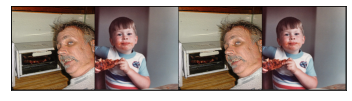

In [35]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

image1_int = read_image(str('photo_test_copy.jpg'))
image2_int = read_image(str('photo_test2_copy.jpg'))


grid = make_grid([image1_int, image2_int, image1_int, image2_int])
show(grid)

## Visualizing bounding boxes
We can use :func:`~torchvision.utils.draw_bounding_boxes` to draw boxes on an
image. We can set the colors, labels, width as well as font and font size.
The boxes are in ``(xmin, ymin, xmax, ymax)`` format.



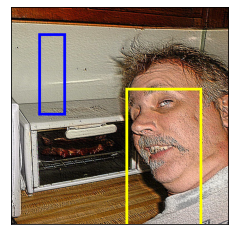

In [36]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [210, 150, 350, 430]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(image1_int, boxes, colors=colors, width=5)
show(result)

Naturally, we can also plot bounding boxes produced by torchvision detection
models.  Here is demo with a Faster R-CNN model loaded from
:func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`
model. You can also try using a RetinaNet with
:func:`~torchvision.models.detection.retinanet_resnet50_fpn`, an SSDlite with
:func:`~torchvision.models.detection.ssdlite320_mobilenet_v3_large` or an SSD with
:func:`~torchvision.models.detection.ssd300_vgg16`. For more details
on the output of such models, you may refer to `instance_seg_output`.



In [37]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype


batch_int = torch.stack([image1_int, image2_int])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

outputs = model(batch)
print(outputs)

[{'boxes': tensor([[153.4339,  54.8493, 396.8792, 399.2241],
        [  6.4081, 177.3195, 235.0187, 345.5114],
        [  4.4058, 129.0723, 318.3652, 385.9572],
        [ 94.4475, 216.2417, 194.0568, 243.1420],
        [  0.5927, 174.4346,  21.2352, 388.1983],
        [134.2247, 113.6843, 139.1721, 119.7678],
        [ 92.6868, 215.7786, 196.4046, 242.3931],
        [  0.0000, 177.0313, 237.8324, 356.9510],
        [  6.3398, 173.6040, 251.0356, 358.5844],
        [  1.2113, 169.3948,  24.6084, 384.4564],
        [ 56.2547, 233.9472, 191.2869, 280.6852],
        [ 54.2679, 232.6239, 190.5265, 281.8221],
        [  0.0000, 110.5347, 372.7703, 372.0576]], grad_fn=<StackBackward>), 'labels': tensor([ 1, 79, 79, 75, 82,  1, 49, 78, 15, 79, 59, 61, 15]), 'scores': tensor([0.9738, 0.8944, 0.2628, 0.2599, 0.1453, 0.1234, 0.1080, 0.1068, 0.0837,
        0.0821, 0.0623, 0.0594, 0.0584], grad_fn=<IndexBackward>)}, {'boxes': tensor([[  0.0000,  55.1895, 268.1879, 392.2712],
        [  0.8414, 249

Let's plot the boxes detected by our model. We will only plot the boxes with a
score greater than a given threshold.



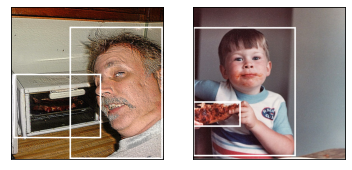

In [38]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)

## Visualizing segmentation masks
The :func:`~torchvision.utils.draw_segmentation_masks` function can be used to
draw segmentation masks on images. Semantic segmentation and instance
segmentation models have different outputs, so we will treat each
independently.


### Semantic segmentation models

We will see how to use it with torchvision's FCN Resnet-50, loaded with
:func:`~torchvision.models.segmentation.fcn_resnet50`.  You can also try using
DeepLabv3 (:func:`~torchvision.models.segmentation.deeplabv3_resnet50`) or
lraspp mobilenet models
(:func:`~torchvision.models.segmentation.lraspp_mobilenet_v3_large`).

Let's start by looking at the ouput of the model. Remember that in general,
images must be normalized before they're passed to a semantic segmentation
model.



In [39]:
from torchvision.models.segmentation import fcn_resnet50


model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()

normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([2, 21, 400, 400]) -5.238720893859863 14.196565628051758


As we can see above, the output of the segmentation model is a tensor of shape
``(batch_size, num_classes, H, W)``. Each value is a non-normalized score, and
we can normalize them into ``[0, 1]`` by using a softmax. After the softmax,
we can interpret each value as a probability indicating how likely a given
pixel is to belong to a given class.

Let's plot the masks that have been detected for the dog class and for the
boat class:



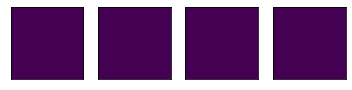

In [40]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(batch.shape[0])
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)

As expected, the model is confident about the dog class, but not so much for
the boat class.

The :func:`~torchvision.utils.draw_segmentation_masks` function can be used to
plots those masks on top of the original image. This function expects the
masks to be boolean masks, but our masks above contain probabilities in ``[0,
1]``. To get boolean masks, we can do the following:



shape = torch.Size([2, 400, 400]), dtype = torch.bool


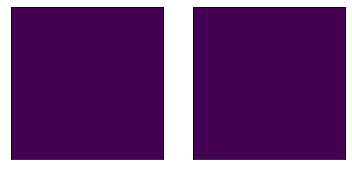

In [41]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

The line above where we define ``boolean_dog_masks`` is a bit cryptic, but you
can read it as the following query: "For which pixels is 'dog' the most likely
class?"

<div class="alert alert-info"><h4>Note</h4><p>While we're using the ``normalized_masks`` here, we would have
  gotten the same result by using the non-normalized scores of the model
  directly (as the softmax operation preserves the order).</p></div>

Now that we have boolean masks, we can use them with
:func:`~torchvision.utils.draw_segmentation_masks` to plot them on top of the
original images:



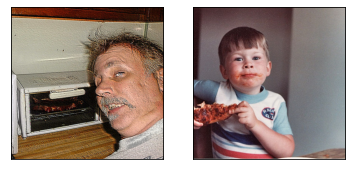

In [42]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(batch_int, boolean_dog_masks)
]
show(dogs_with_masks)

We can plot more than one mask per image! Remember that the model returned as
many masks as there are classes. Let's ask the same query as above, but this
time for *all* classes, not just the dog class: "For each pixel and each class
C, is class C the most most likely class?"

This one is a bit more involved, so we'll first show how to do it with a
single image, and then we'll generalize to the batch



image1_masks shape = torch.Size([21, 400, 400]), dtype = torch.float32
image1_all_classes_masks = torch.Size([21, 400, 400]), dtype = torch.bool


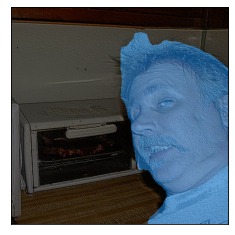

In [43]:
num_classes = normalized_masks.shape[1]
image1_masks = normalized_masks[0]
class_dim = 0
image1_all_classes_masks = image1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"image1_masks shape = {image1_masks.shape}, dtype = {image1_masks.dtype}")
print(f"image1_all_classes_masks = {image1_all_classes_masks.shape}, dtype = {image1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(image1_int, masks=image1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

We can see in the image above that only 2 masks were drawn: the mask for the
background and the mask for the dog. This is because the model thinks that
only these 2 classes are the most likely ones across all the pixels. If the
model had detected another class as the most likely among other pixels, we
would have seen its mask above.

Removing the background mask is as simple as passing
``masks=image1_all_classes_masks[1:]``, because the background class is the
class with index 0.

Let's now do the same but for an entire batch of images. The code is similar
but involves a bit more juggling with the dimensions.



shape = torch.Size([21, 2, 400, 400]), dtype = torch.bool


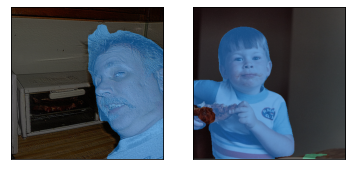

In [44]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(batch_int, all_classes_masks)
]
show(dogs_with_masks)


### Instance segmentation models

Instance segmentation models have a significantly different output from the
semantic segmentation models. We will see here how to plot the masks for such
models. Let's start by analyzing the output of a Mask-RCNN model. Note that
these models don't require the images to be normalized, so we don't need to
use the normalized batch.

<div class="alert alert-info"><h4>Note</h4><p>We will here describe the output of a Mask-RCNN model. The models in
    `object_det_inst_seg_pers_keypoint_det` all have a similar output
    format, but some of them may have extra info like keypoints for
    :func:`~torchvision.models.detection.keypointrcnn_resnet50_fpn`, and some
    of them may not have masks, like
    :func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`.</p></div>



In [45]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
model = maskrcnn_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

output = model(batch)
print(output)

[{'boxes': tensor([[157.8392,  60.9407, 400.0000, 397.3546],
        [ 11.5063, 133.4458, 249.3453, 359.4986],
        [  6.3069, 142.5911, 257.4333, 360.2014],
        [214.7043,  39.6933, 378.3979,  98.5522],
        [  0.5388, 169.4767,  20.5198, 391.1143],
        [  6.1421,  42.0366, 331.7101, 377.5485],
        [  4.4700,  42.1216, 358.9036, 379.3142],
        [  4.3987,  99.6038, 298.0030, 380.5452],
        [  5.0202,  59.2408, 317.4545, 382.9207]], grad_fn=<StackBackward>), 'labels': tensor([ 1, 79, 78, 20, 82, 79,  3, 15,  6]), 'scores': tensor([0.9730, 0.7414, 0.1576, 0.1527, 0.1400, 0.0993, 0.0842, 0.0803, 0.0699],
       grad_fn=<IndexBackward>), 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2709, 0.2331, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.2

Let's break this down. For each image in the batch, the model outputs some
detections (or instances). The number of detections varies for each input
image. Each instance is described by its bounding box, its label, its score
and its mask.

The way the output is organized is as follows: the output is a list of length
``batch_size``. Each entry in the list corresponds to an input image, and it
is a dict with keys 'boxes', 'labels', 'scores', and 'masks'. Each value
associated to those keys has ``num_instances`` elements in it.  In our case
above there are 3 instances detected in the first image, and 2 instances in
the second one.

The boxes can be plotted with :func:`~torchvision.utils.draw_bounding_boxes`
as above, but here we're more interested in the masks. These masks are quite
different from the masks that we saw above for the semantic segmentation
models.



In [46]:
image1_output = output[0]
image1_masks = image1_output['masks']
print(f"shape = {image1_masks.shape}, dtype = {image1_masks.dtype}, "
      f"min = {image1_masks.min()}, max = {image1_masks.max()}")

shape = torch.Size([9, 1, 400, 400]), dtype = torch.float32, min = 0.0, max = 0.9998392462730408


Here the masks corresponds to probabilities indicating, for each pixel, how
likely it is to belong to the predicted label of that instance. Those
predicted labels correspond to the 'labels' element in the same output dict.
Let's see which labels were predicted for the instances of the first image.



In [47]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls: idx for (idx, cls) in enumerate(inst_classes)}

print("For the first dog, the following instances were detected:")
print([inst_classes[label] for label in image1_output['labels']])

For the first dog, the following instances were detected:
['person', 'oven', 'microwave', 'sheep', 'refrigerator', 'oven', 'car', 'bench', 'bus']


Interestingly, the model detects two persons in the image. Let's go ahead and
plot those masks. Since :func:`~torchvision.utils.draw_segmentation_masks`
expects boolean masks, we need to convert those probabilities into boolean
values. Remember that the semantic of those masks is "How likely is this pixel
to belong to the predicted class?". As a result, a natural way of converting
those masks into boolean values is to threshold them with the 0.5 probability
(one could also choose a different threshold).



shape = torch.Size([9, 1, 400, 400]), dtype = torch.bool


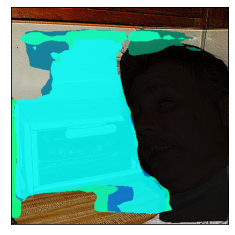

In [48]:
proba_threshold = 0.5
image1_bool_masks = image1_output['masks'] > proba_threshold
print(f"shape = {image1_bool_masks.shape}, dtype = {image1_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
image1_bool_masks = image1_bool_masks.squeeze(1)

show(draw_segmentation_masks(image1_int, image1_bool_masks, alpha=0.9))

The model seems to have properly detected the dog, but it also confused trees
with people. Looking more closely at the scores will help us plotting more
relevant masks:



In [49]:
print(image1_output['scores'])

tensor([0.9730, 0.7414, 0.1576, 0.1527, 0.1400, 0.0993, 0.0842, 0.0803, 0.0699],
       grad_fn=<IndexBackward>)


Clearly the model is less confident about the dog detection than it is about
the people detections. That's good news. When plotting the masks, we can ask
for only those that have a good score. Let's use a score threshold of .75
here, and also plot the masks of the second dog.



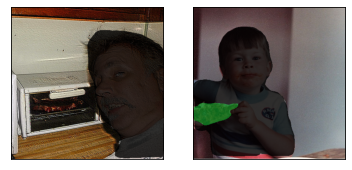

In [50]:
score_threshold = .75

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
]

dogs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(batch_int, boolean_masks)
]
show(dogs_with_masks)

The two 'people' masks in the first image where not selected because they have
a lower score than the score threshold. Similarly in the second image, the
instance with class 15 (which corresponds to 'bench') was not selected.

